--- 1. Load Data & Preprocessing ---
Loading data from: C:\Users\mason\AVP\BTCUSDrec.csv
Raw data loaded. Shape: (15177, 9)
Selected the last 15000 rows for backtesting.
Data prepared for feature engineering. Shape: (15000, 7)

--- 2. Feature Engineering (Script C - Script B + Pandas TA) ---
Generating features (Script B + Pandas TA)...
  Adding selected pandas_ta features...
Feature calculation complete. Returning 15000 rows with 61 columns.
Feature calculation completed in 0.13 seconds.
Total columns after feature engineering: 61

--- 3. Define Target Variable ---
Defining target variable: Price change > 0 over next 12 hours...
Preparing data for modeling...
Identified 53 columns as features for modeling.
Handled NaNs/Infs. Dropped 184 rows.
Defining final Features (X) and Binary Target (y)...
Final feature matrix shape: (14816, 53)
Target vector shape: (14816,)
Number of feature columns used: 53

--- Starting Rolling Backtest (Single XGBoost) ---
Initial Train Size: 1344 rows (1344h

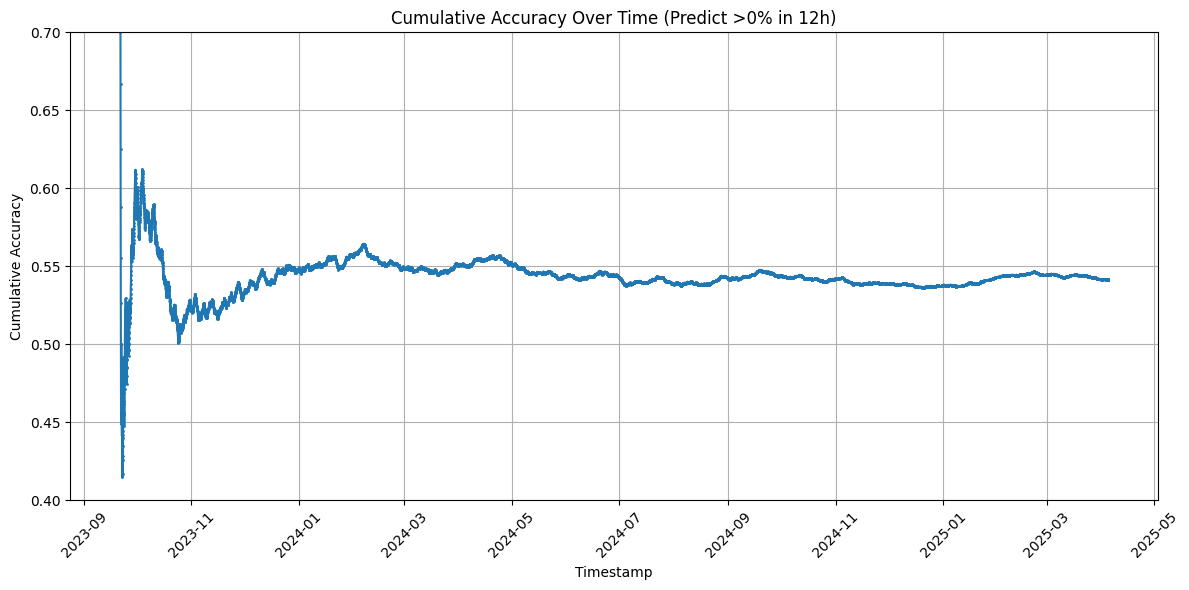


Script finished.


In [4]:
import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime
import matplotlib.pyplot as plt

# Feature Engineering Imports
import pandas_ta as ta  # Technical indicators

# Modeling Imports
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore')

# --- Configuration ---
CSV_FILE_PATH = r'C:\Users\mason\AVP\BTCUSDrec.csv'
SYMBOL_NAME = 'BTCUSD'
PREDICTION_HORIZON_HOURS = 12
TARGET_COL_CALC = f'price_change_{PREDICTION_HORIZON_HOURS}h'
TARGET_COL_BINARY = 'target'
INITIAL_TRAIN_SIZE_HOURS = 24 * 7 * 8  # ~2 months initial training
STEP_SIZE_HOURS = 24               # Retrain every day

XGB_PARAMS = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 4,
    'n_estimators': 150,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0.1,
    'lambda': 1.0,
    'alpha': 0.1,
    'use_label_encoder': False,
    'random_state': 42,
    'n_jobs': -1,
}

# --- Helper Functions ---
def safe_divide(numerator, denominator):
    num = pd.Series(numerator) if not isinstance(numerator, pd.Series) else numerator
    den = pd.Series(denominator) if not isinstance(denominator, pd.Series) else denominator
    if den is not None and not den.empty:
        num_aligned, den_aligned = num.align(den, join='left')
        with np.errstate(divide='ignore', invalid='ignore'):
            result = num_aligned / den_aligned.replace(0, np.nan)
        return result.replace([np.inf, -np.inf], np.nan)
    return pd.Series(np.nan, index=num.index if hasattr(num, 'index') else None)

def safe_log(col):
    s = pd.Series(col) if not isinstance(col, pd.Series) else col
    if s is not None and not s.empty and pd.api.types.is_numeric_dtype(s):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.log(np.maximum(s, 1e-9))
        return result.replace([np.inf, -np.inf], np.nan)
    return pd.Series(np.nan, index=s.index if hasattr(s, 'index') else None)

def safe_sqrt(col):
    s = pd.Series(col) if not isinstance(col, pd.Series) else col
    if s is not None and not s.empty and pd.api.types.is_numeric_dtype(s):
        return np.sqrt(s.clip(lower=0))
    return pd.Series(np.nan, index=s.index if hasattr(s, 'index') else None)

def safe_subtract(series1, series2):
    s1 = pd.Series(series1); s2 = pd.Series(series2)
    if s1 is not None and not s1.empty and s2 is not None and not s2.empty and pd.api.types.is_numeric_dtype(s1) and pd.api.types.is_numeric_dtype(s2):
        s1_aligned, s2_aligned = s1.align(s2, join='left')
        return s1_aligned - s2_aligned
    idx = s1.index if hasattr(s1, 'index') else (s2.index if hasattr(s2, 'index') else None)
    return pd.Series(np.nan, index=idx)

# --- Feature Engineering Function ---
def calculate_script_c_features(df):
    """
    Generates features from Script B and adds selected pandas_ta indicators.
    """
    print("Generating features (Script B + Pandas TA)...")
    df = df.copy()

    # --- Ensure required columns and timestamp ---
    required = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD', 'timestamp']
    if not all(col in df.columns for col in required):
        missing = [col for col in required if col not in df.columns]
        print(f"Error: Missing required base columns: {missing}")
        return pd.DataFrame()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    for col in ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=required)
    if df.empty: 
        return pd.DataFrame()
    df = df.set_index('timestamp', drop=False)

    # --- Start of Script B Feature Calculations ---
    # Basic Features
    df['price_change_1h'] = df['close'].pct_change() * 100
    df['price_range_pct'] = safe_divide(df['high'] - df['low'], df['close']) * 100
    df['oc_change_pct'] = safe_divide(df['close'] - df['open'], df['open']) * 100

    # Volatility Features
    def garman_klass_volatility(open_, high, low, close, window):
        log_hl = safe_log(safe_divide(high, low))
        log_co = safe_log(safe_divide(close, open_))
        gk = 0.5 * (log_hl ** 2) - (2*np.log(2) - 1) * (log_co ** 2)
        return safe_sqrt(gk.rolling(window=window, min_periods=window//2).mean())
    def parkinson_volatility(high, low, window):
        log_hl_sq = safe_log(safe_divide(high, low)) ** 2
        rolling_sum = log_hl_sq.rolling(window=window, min_periods=window//2).sum()
        factor = 1 / (4 * np.log(2) * window)
        return safe_sqrt(factor * rolling_sum)
    df['garman_klass_12h'] = garman_klass_volatility(df['open'], df['high'], df['low'], df['close'], window=12)
    df['parkinson_3h'] = parkinson_volatility(df['high'], df['low'], window=3)

    # Moving Averages & Standard Deviations
    min_periods_ma = 3
    df['ma_3h'] = df['close'].rolling(window=3, min_periods=min_periods_ma).mean()
    df['rolling_std_3h'] = df['close'].rolling(window=3, min_periods=min_periods_ma).std()

    # Lagged Features
    df['price_return_1h_feat'] = df['close'].pct_change()
    lag_periods_price = [3, 6, 12, 24, 48, 72, 168]
    for lag in lag_periods_price:
        df[f'lag_{lag}h_price_return'] = df['price_return_1h_feat'].shift(lag) * 100
    df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100
    lag_periods_volume = [3, 6, 12, 24]
    for lag in lag_periods_volume:
         df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag)

    # Longer MAs and STDs
    ma_periods = [6, 12, 24, 48, 72, 168]
    std_periods = [6, 12, 24, 48, 72, 168]
    for p in ma_periods:
        df[f'ma_{p}h'] = df['close'].rolling(window=p, min_periods=p//2).mean()
    for p in std_periods:
        df[f'rolling_std_{p}h'] = df['price_return_1h_feat'].rolling(window=p, min_periods=p//2).std() * 100

    # ATR
    try:
        df['tr'] = ta.true_range(df['high'], df['low'], df['close'])
        atr_periods = [14, 24, 48]
        for p in atr_periods:
            df[f'atr_{p}h'] = ta.atr(df['high'], df['low'], df['close'], length=p)
    except Exception as e_atr:
        print(f"Warning: ATR calculation failed: {e_atr}")
        for p in atr_periods:
            df[f'atr_{p}h'] = np.nan
        if 'tr' not in df.columns:
            df['tr'] = np.nan

    # Trend/Interaction Features
    for p in [24, 48, 168]:
        df[f'close_div_ma_{p}h'] = safe_divide(df['close'], df.get(f'ma_{p}h'))
    df['ma12_div_ma48'] = safe_divide(df.get('ma_12h'), df.get('ma_48h'))
    df['ma24_div_ma168'] = safe_divide(df.get('ma_24h'), df.get('ma_168h'))
    df['std12_div_std72'] = safe_divide(df.get('rolling_std_12h'), df.get('rolling_std_72h'))
    if 'price_range_pct' in df.columns and 'Volume BTC' in df.columns:
        df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']
    else:
        df['volume_btc_x_range'] = np.nan

    # Non-linear Transformations
    if 'rolling_std_3h' in df.columns:
        df['rolling_std_3h_sq'] = df['rolling_std_3h'] ** 2
    else:
        df['rolling_std_3h_sq'] = np.nan
    # FIX: Compute squared return using the correct column name
    if 'price_return_1h_feat' in df.columns:
        df['price_return_1h_sq'] = df['price_return_1h_feat'] ** 2 * 10000
    else:
        df['price_return_1h_sq'] = np.nan
    if 'rolling_std_12h' in df.columns:
         df['rolling_std_12h_sqrt'] = safe_sqrt(df['rolling_std_12h'])
    else:
         df['rolling_std_12h_sqrt'] = np.nan

    # Drop intermediate price return AFTER computing its square
    if 'price_return_1h_feat' in df.columns:
         df = df.drop(columns=['price_return_1h_feat'])

    # --- Add Selected Pandas TA Features ---
    print("  Adding selected pandas_ta features...")
    df_ta = df.rename(columns={'Volume BTC': 'volume'}, errors='ignore')
    try:
        df['rsi_14h'] = ta.rsi(df_ta['close'], length=14)
    except Exception as e:
        print(f"Warning: RSI failed: {e}")
        df['rsi_14h'] = np.nan
    try:
        macd_df = ta.macd(df_ta['close'])
        df = pd.concat([df, macd_df], axis=1)
    except Exception as e:
        print(f"Warning: MACD failed: {e}")
        df['MACD_12_26_9'], df['MACDh_12_26_9'], df['MACDs_12_26_9'] = np.nan, np.nan, np.nan
    if 'volume' in df_ta.columns:
         try:
             df['cmf_20h'] = ta.cmf(df_ta['high'], df_ta['low'], df_ta['close'], df_ta['volume'], length=20)
         except Exception as e:
             print(f"Warning: CMF failed: {e}")
             df['cmf_20h'] = np.nan
    else:
         df['cmf_20h'] = np.nan
    try:
        df['cci_20h'] = ta.cci(df_ta['high'], df_ta['low'], df_ta['close'], length=20)
    except Exception as e:
        print(f"Warning: CCI failed: {e}")
        df['cci_20h'] = np.nan
    try:
        bbands_df = ta.bbands(df_ta['close'], length=20)
        df['bband_width_20h'] = bbands_df['BBB_20_2.0']
    except Exception as e:
        print(f"Warning: BBands Width failed: {e}")
        df['bband_width_20h'] = np.nan
    try:
        adx_df = ta.adx(df_ta['high'], df_ta['low'], df_ta['close'], length=14)
        df['adx_14h'] = adx_df['ADX_14']
    except Exception as e:
        print(f"Warning: ADX failed: {e}")
        df['adx_14h'] = np.nan
    try:
        stochrsi_df = ta.stochrsi(df_ta['close'], length=14)
        df['stoch_rsi_k'] = stochrsi_df['STOCHRSIk_14_14_3_3']
        df['stoch_rsi_d'] = stochrsi_df['STOCHRSId_14_14_3_3']
    except Exception as e:
        print(f"Warning: StochRSI failed: {e}")
        df['stoch_rsi_k'], df['stoch_rsi_d'] = np.nan, np.nan

    # Rename MACD columns for consistency
    df.rename(columns={'MACD_12_26_9': 'macd',
                       'MACDh_12_26_9': 'macd_hist',
                       'MACDs_12_26_9': 'macd_signal'}, inplace=True, errors='ignore')

    # --- Final Cleanup ---
    df = df.reset_index(drop=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.drop(columns=['tr'], errors='ignore')

    print(f"Feature calculation complete. Returning {len(df)} rows with {len(df.columns)} columns.")
    return df

# --- Main Execution Block ---
if __name__ == "__main__":
    print("--- 1. Load Data & Preprocessing ---")
    try:
        print(f"Loading data from: {CSV_FILE_PATH}")
        col_names = ['unix', 'date', 'symbol_csv', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
        df_raw = pd.read_csv(CSV_FILE_PATH, header=0, names=col_names)
        print(f"Raw data loaded. Shape: {df_raw.shape}")

        if 'date' in df_raw.columns:
            df_raw['timestamp'] = pd.to_datetime(df_raw['date'])
        elif 'unix' in df_raw.columns:
            df_raw['timestamp'] = pd.to_datetime(df_raw['unix'], unit='ms')
        else:
            exit("Error: Cannot find 'date' or 'unix' column.")
        cols_to_drop_init = ['unix', 'date', 'symbol_csv']
        df_raw = df_raw.drop(columns=cols_to_drop_init, errors='ignore')
        df_raw = df_raw.sort_values('timestamp').reset_index(drop=True)

        N_ROWS = 15000
        if len(df_raw) >= N_ROWS:
             df = df_raw.iloc[-N_ROWS:].reset_index(drop=True)
             print(f"Selected the last {len(df)} rows for backtesting.")
        else:
             df = df_raw.copy()
             print(f"Using all {len(df)} available rows (less than {N_ROWS}).")

        if df.empty:
            exit("DataFrame empty after initial processing. Exiting.")

        cols_to_pass = ['timestamp', 'open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
        df_for_features = df[[col for col in cols_to_pass if col in df.columns]].copy()
        print(f"Data prepared for feature engineering. Shape: {df_for_features.shape}")

    except Exception as e:
        print(f"Error loading data: {e}")
        traceback.print_exc()
        exit()

    print("\n--- 2. Feature Engineering (Script C - Script B + Pandas TA) ---")
    feature_calc_start = time.time()
    df_features = calculate_script_c_features(df_for_features)
    feature_calc_end = time.time()
    if df_features.empty:
        exit("Feature calculation failed. Exiting.")
    print(f"Feature calculation completed in {feature_calc_end - feature_calc_start:.2f} seconds.")
    print(f"Total columns after feature engineering: {len(df_features.columns)}")

    print("\n--- 3. Define Target Variable ---")
    target_shift = -PREDICTION_HORIZON_HOURS
    print(f"Defining target variable: Price change > 0 over next {PREDICTION_HORIZON_HOURS} hours...")
    if 'close' not in df_features.columns:
         print("FATAL ERROR: 'close' column missing after feature engineering.")
         exit()
    df_features[TARGET_COL_CALC] = df_features['close'].shift(target_shift)\
                                    .sub(df_features['close'])\
                                    .div(df_features['close'].replace(0, np.nan))\
                                    .mul(100)
    df_features[TARGET_COL_BINARY] = (df_features[TARGET_COL_CALC] > 0).astype(int)

    print("Preparing data for modeling...")
    NON_FEATURE_COLS = [
        'unix', 'date', 'symbol', 'open', 'high', 'low', 'close',
        'Volume BTC', 'Volume USD', 'timestamp', TARGET_COL_BINARY, TARGET_COL_CALC,
        'price_change_1h',
        'prev_close', 'high_minus_low', 'high_minus_prev_close',
        'low_minus_prev_close', 'true_range', 'macd_temp',
    ]
    feature_cols = [col for col in df_features.columns if col not in NON_FEATURE_COLS]
    print(f"Identified {len(feature_cols)} columns as features for modeling.")

    final_model_cols = ['timestamp'] + feature_cols + [TARGET_COL_BINARY]
    final_model_cols_present = [col for col in final_model_cols if col in df_features.columns]
    df_model_ready = df_features[final_model_cols_present].copy()

    df_model_ready = df_model_ready.replace([np.inf, -np.inf], np.nan)
    initial_rows = len(df_model_ready)
    cols_to_check_for_nan = feature_cols + [TARGET_COL_BINARY]
    cols_to_check_for_nan = [col for col in cols_to_check_for_nan if col in df_model_ready.columns]
    df_model_ready = df_model_ready.dropna(subset=cols_to_check_for_nan)
    final_rows = len(df_model_ready)
    print(f"Handled NaNs/Infs. Dropped {initial_rows - final_rows} rows.")

    initial_train_size_rows = INITIAL_TRAIN_SIZE_HOURS
    step_size_rows = STEP_SIZE_HOURS

    if final_rows < initial_train_size_rows + step_size_rows:
         print(f"Error: Not enough data ({final_rows} rows) remaining after NaN handling for initial training size ({initial_train_size_rows}) and step ({step_size_rows}).")
         exit()

    print("Defining final Features (X) and Binary Target (y)...")
    X = df_model_ready[feature_cols]
    y_binary = df_model_ready[TARGET_COL_BINARY]
    timestamps = df_model_ready['timestamp']

    print(f"Final feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y_binary.shape}")
    print(f"Number of feature columns used: {len(X.columns)}")

    print("\n--- Starting Rolling Backtest (Single XGBoost) ---")
    print(f"Initial Train Size: {initial_train_size_rows} rows ({INITIAL_TRAIN_SIZE_HOURS}h)")
    print(f"Step Size: {step_size_rows} rows ({STEP_SIZE_HOURS}h)")

    all_predictions = []
    all_actual = []
    all_probabilities = []
    backtest_timestamps = []
    num_predictions_total = 0
    start_loop_time = time.time()

    for i in range(initial_train_size_rows, len(X), step_size_rows):
        train_idx_end = i
        test_idx_start = i
        test_idx_end = min(i + step_size_rows, len(X))
        if test_idx_start >= test_idx_end: break

        X_train_roll = X.iloc[:train_idx_end]
        y_train_roll = y_binary.iloc[:train_idx_end]
        X_test_roll = X.iloc[test_idx_start:test_idx_end]
        y_test_roll_actual = y_binary.iloc[test_idx_start:test_idx_end]
        current_timestamps = timestamps.iloc[test_idx_start:test_idx_end]
        if len(X_test_roll) == 0: continue

        iter_num = (i - initial_train_size_rows) // step_size_rows + 1

        neg_count = (y_train_roll == 0).sum()
        pos_count = (y_train_roll == 1).sum()
        scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

        model_roll = xgb.XGBClassifier(**XGB_PARAMS, scale_pos_weight=scale_pos_weight)
        model_roll.fit(X_train_roll, y_train_roll, verbose=False)

        pred_roll = model_roll.predict(X_test_roll)
        prob_roll = model_roll.predict_proba(X_test_roll)[:, 1]

        all_predictions.extend(pred_roll.tolist())
        all_actual.extend(y_test_roll_actual.tolist())
        all_probabilities.extend(prob_roll.tolist())
        backtest_timestamps.extend(current_timestamps.tolist())
        num_predictions_total += len(pred_roll)

        if iter_num % 20 == 0:
             print(f"  Iteration {iter_num} complete. Processed {num_predictions_total} total predictions.")

    end_loop_time = time.time()
    loop_duration_minutes = (end_loop_time - start_loop_time) / 60
    print(f"\nBacktesting finished in {end_loop_time - start_loop_time:.2f} seconds ({loop_duration_minutes:.2f} minutes). Made {num_predictions_total} predictions.")

    if num_predictions_total > 0:
        if not (len(all_actual) == len(all_predictions)):
            print("Error: Result list lengths mismatch!")
        else:
            final_accuracy = accuracy_score(all_actual, all_predictions)
            final_precision = precision_score(all_actual, all_predictions, zero_division=0)
            final_recall = recall_score(all_actual, all_predictions, zero_division=0)
            final_f1 = f1_score(all_actual, all_predictions, zero_division=0)

            print("\n--- Backtesting Performance Metrics ---")
            print(f"Target: Price Change > 0% over {PREDICTION_HORIZON_HOURS} hours")
            print(f"Training Window: Expanding (Starts {INITIAL_TRAIN_SIZE_HOURS}h)")
            print(f"Step Size: {STEP_SIZE_HOURS}h")
            print(f"Number of Features Used: {len(feature_cols)}")
            print("-" * 20)
            print(f"Overall Accuracy:  {final_accuracy:.4f}")
            print(f"Overall Precision: {final_precision:.4f}")
            print(f"Overall Recall:    {final_recall:.4f}")
            print(f"Overall F1 Score:  {final_f1:.4f}")

            cumulative_correct = np.cumsum(np.array(all_actual) == np.array(all_predictions))
            cumulative_count = np.arange(1, len(all_actual) + 1)
            cumulative_accuracy_plot = cumulative_correct / cumulative_count
            print("\nPlotting cumulative accuracy...")
            try:
                plt.figure(figsize=(12, 6))
                plt.plot(backtest_timestamps, cumulative_accuracy_plot, marker='.', linestyle='-', markersize=2)
                plt.title(f'Cumulative Accuracy Over Time (Predict >0% in {PREDICTION_HORIZON_HOURS}h)')
                plt.xlabel('Timestamp')
                plt.ylabel('Cumulative Accuracy')
                plt.ylim(0.4, 0.7)
                plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            except Exception as e_plot:
                print(f"Could not generate plot: {e_plot}")
    else:
        print("No predictions were made.")

print("\nScript finished.")
